In [1]:
#Импортируем модули
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Волшебная функция обратного преобразования Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [3]:
#Загружаем датасет
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col='month', parse_dates=['month'], dayfirst=True)

#Переименуем колонку
data['salary'] = data['WAG_C_M']
del data['WAG_C_M']
data.head()

,salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


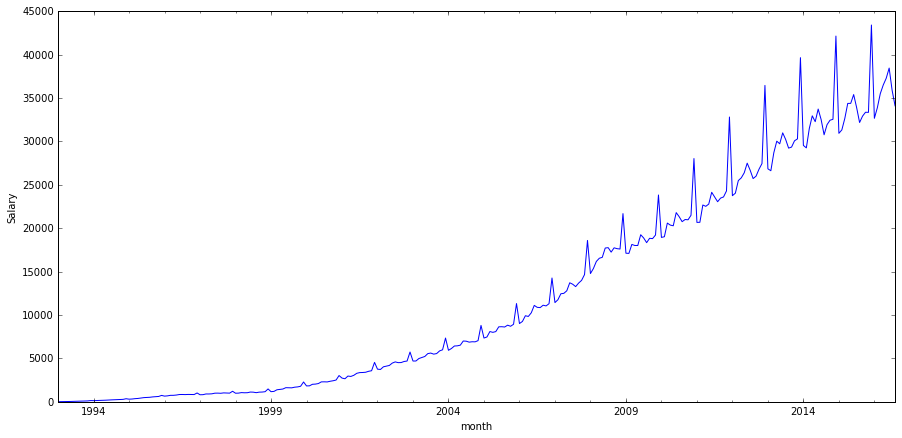

In [4]:
#Посмотрим на данные
plt.figure(figsize(15,7))
data.salary.plot()
plt.ylabel('Salary')
pylab.show()

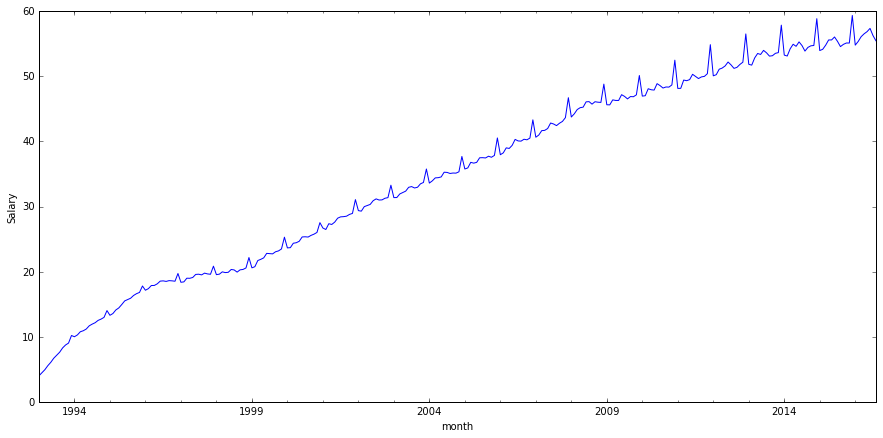

In [5]:
#Ряд явно нестационарен, начнём со стабилизации дисперсии
data['salary_bc'], l_value = stats.boxcox(data.salary)

#Посмотрим на данные
plt.figure(figsize(15,7))
data.salary_bc.plot()
plt.ylabel('Salary')
pylab.show()

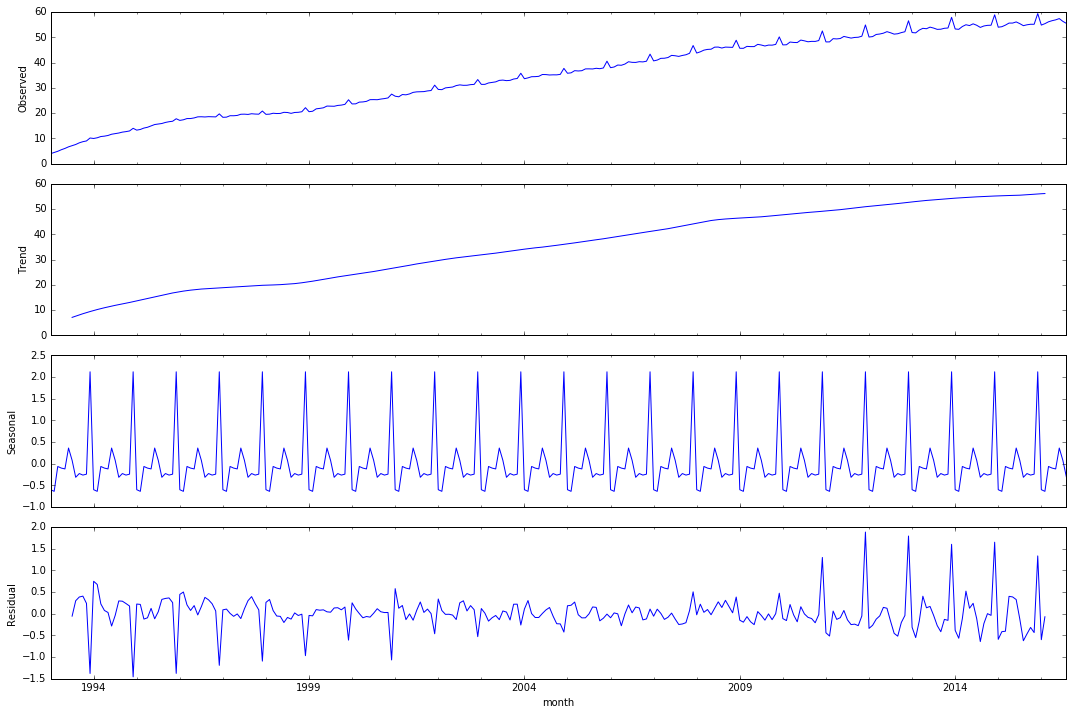

In [6]:
#Уже лучше, посмотрим на декомпозицию ряда
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_bc).plot()
pylab.show()

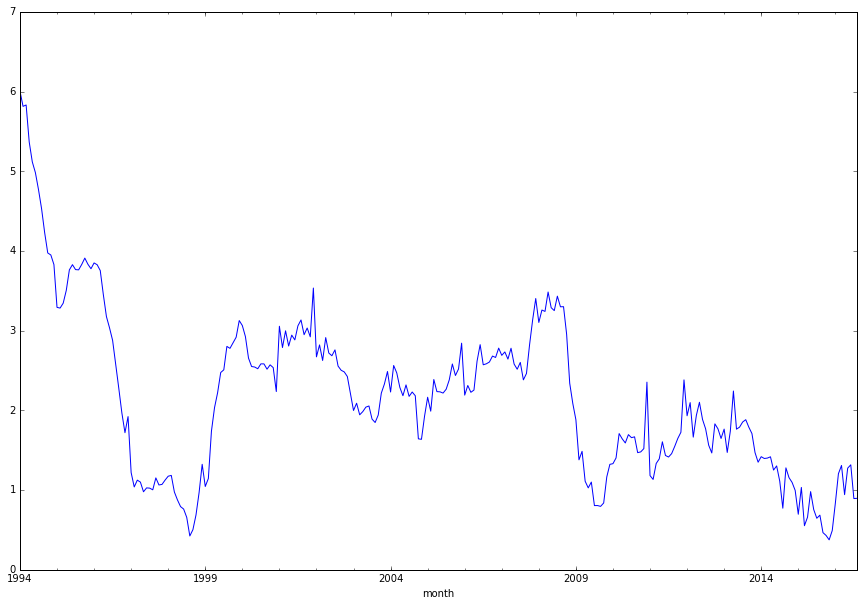

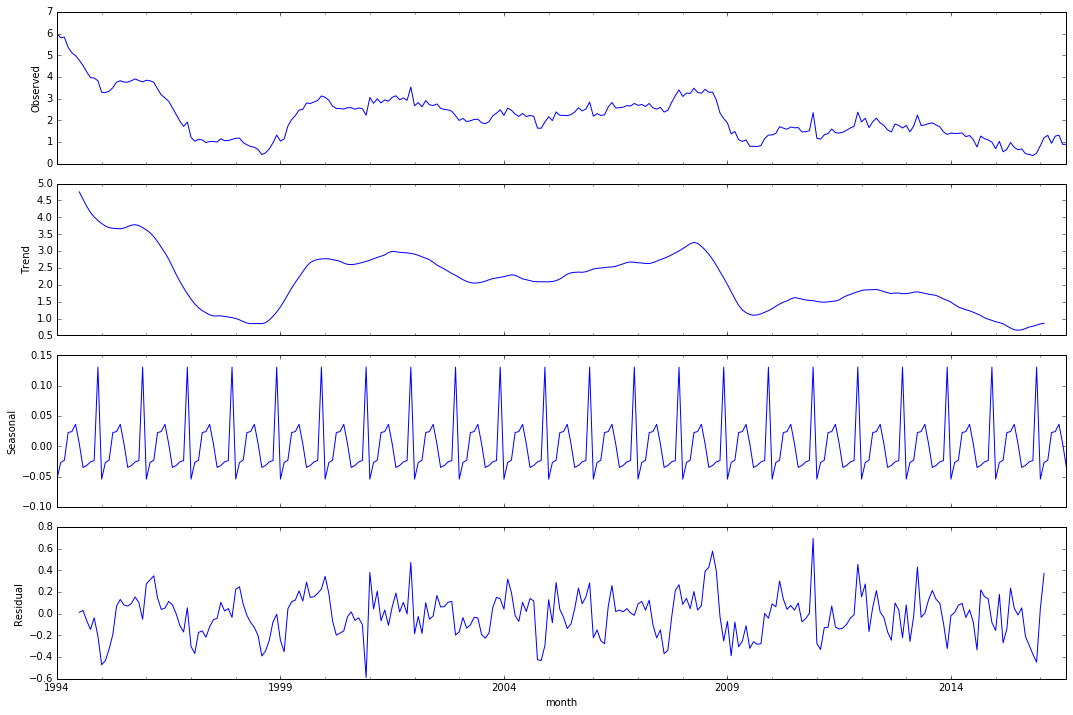

In [7]:
#Виден возрастающий тренд и явная сезонность
#Как рекомендовали, начнём с сезонного дифференцирования
data['salary_bc_df'] = data.salary_bc - data.salary_bc.shift(12)

#Дропнем пустые значение после дифференцирования
data['salary_bc_df'].dropna(inplace=True)

#Посмотрим на график и декомпозицию ряда
data.salary_bc_df.plot()

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_bc_df).plot()
pylab.show()

In [8]:
#Стационарен ли ряд?
print sm.tsa.adfuller(data.salary_bc_df)[1], '< 0.05'

0.0146971334948 < 0.05


## смущает тренд, попробуем дифференцировать на предыдущее значение


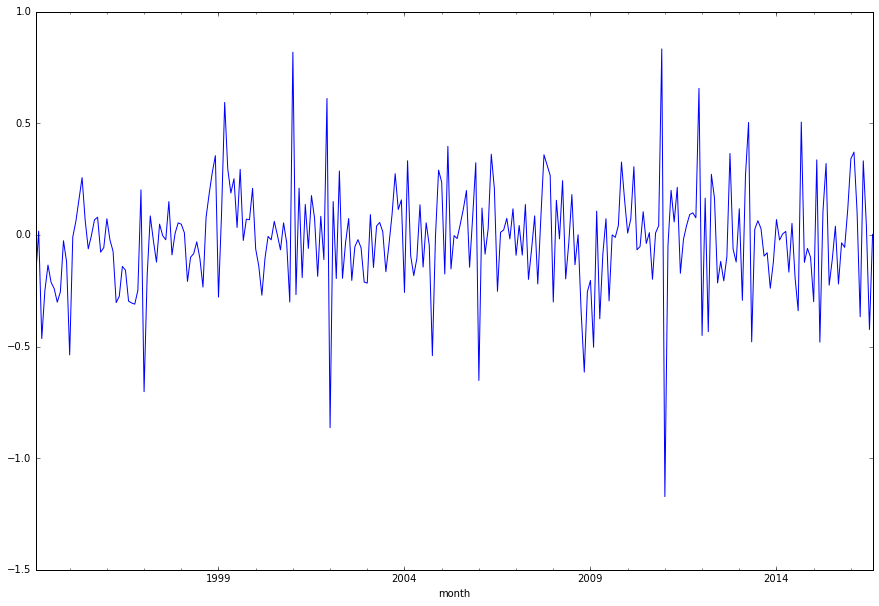

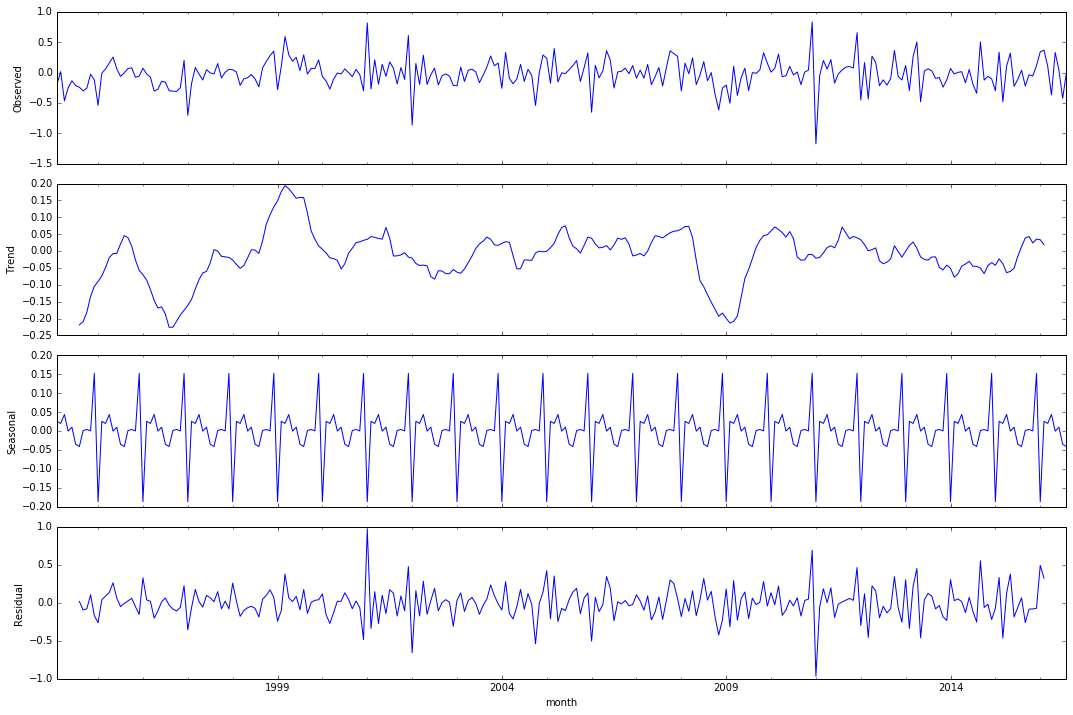

Критерий Дики-Фуллера 5.20360371582e-08 уверенно отвергает нестационарность


In [9]:
data['salary_bc_df2'] = data.salary_bc_df - data.salary_bc_df.shift(1)
#Дропнем пустые значение после дифференцирования
data['salary_bc_df2'].dropna(inplace=True)

#Посмотрим на график и декомпозицию ряда
data.salary_bc_df2.plot()

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_bc_df2).plot()
pylab.show()

#Стационарен ли ряд?
print 'Критерий Дики-Фуллера', sm.tsa.adfuller(data.salary_bc_df2)[1], 'уверенно отвергает нестационарность'

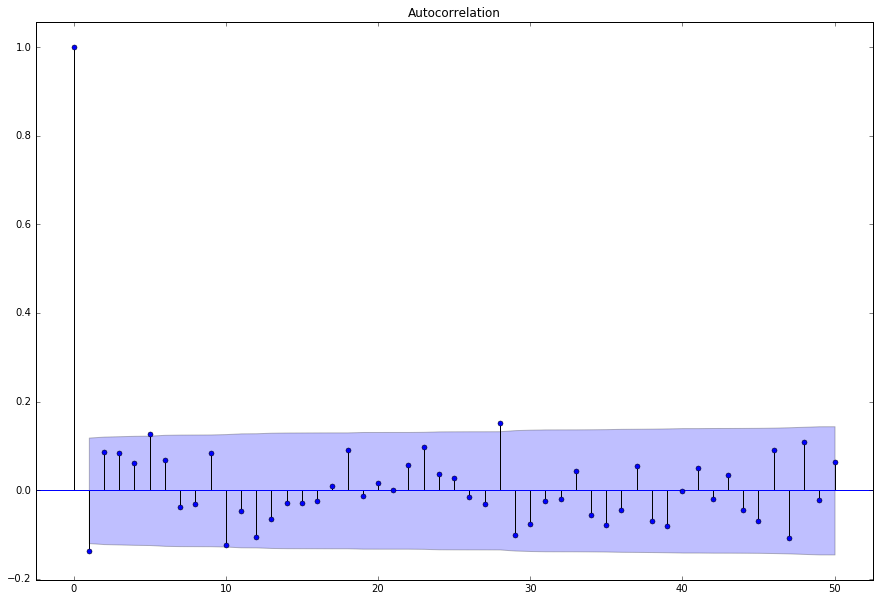

In [10]:
#Посмотрим на график автокорреляции
sm.graphics.tsa.plot_acf(data.salary_bc_df2, lags=50)
pylab.show()

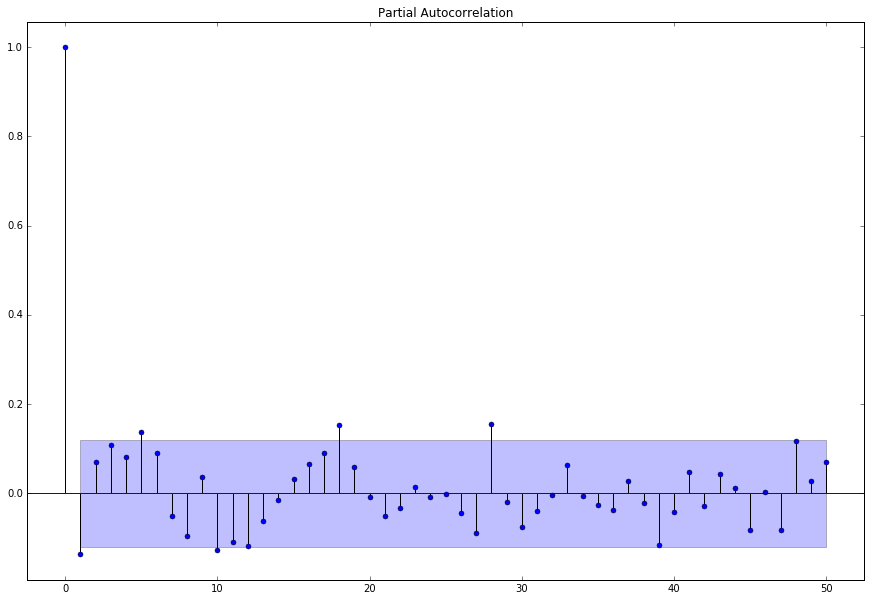

In [11]:
#Посмотрим на график частичной автокорреляции
sm.graphics.tsa.plot_pacf(data.salary_bc_df2, lags=50)
pylab.show()

In [12]:
ps = range(0, 5)
d=1
qs = range(0, 5)
Ps = range(0, 2)#хотя скорее 0
D=1
Qs = range(0, 2)#хотя скорее 0

In [13]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [14]:
%%time

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.salary_bc, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 1))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 1, 1))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 0, 1))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 1, 1))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 0, 1))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', (4, 4, 1, 1))
CPU times: user 1min 37s, sys: 560 ms, total: 1min 37s
Wall time: 38.3 s


In [15]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          salary_bc   No. Observations:                  284
Model:             SARIMAX(1, 1, 4)x(1, 1, 0, 12)   Log Likelihood                  12.484
Date:                            Tue, 08 Nov 2016   AIC                            -10.968
Time:                                    12:58:36   BIC                             14.575
Sample:                                01-01-1993   HQIC                            -0.727
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6984      0.160      4.369      0.000       0.385       1.012
ma.L1         -0.9037      0.169   

Критерий Стьюдента: p=0.549028
Критерий Дики-Фуллера: p=0.000000


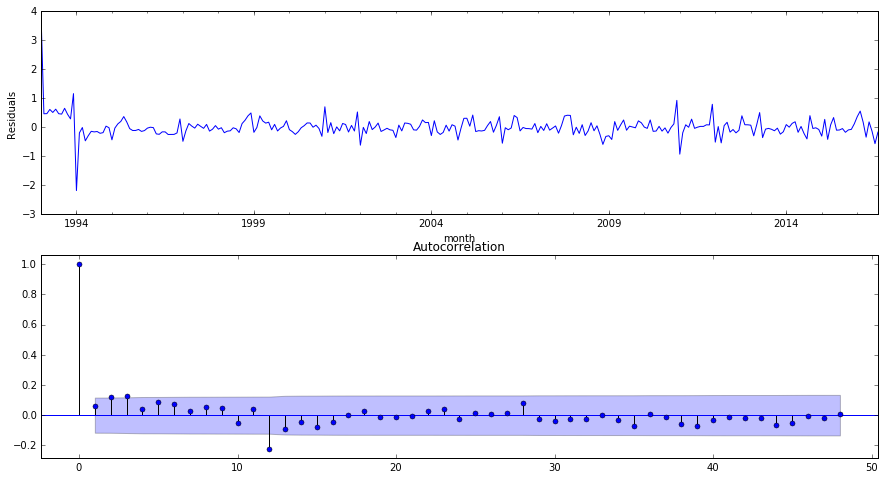

In [16]:
#Посмотрим на остатки лучшей модели
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

### Остатки выглядят несмещёнными и случайными, построим график полученной модели


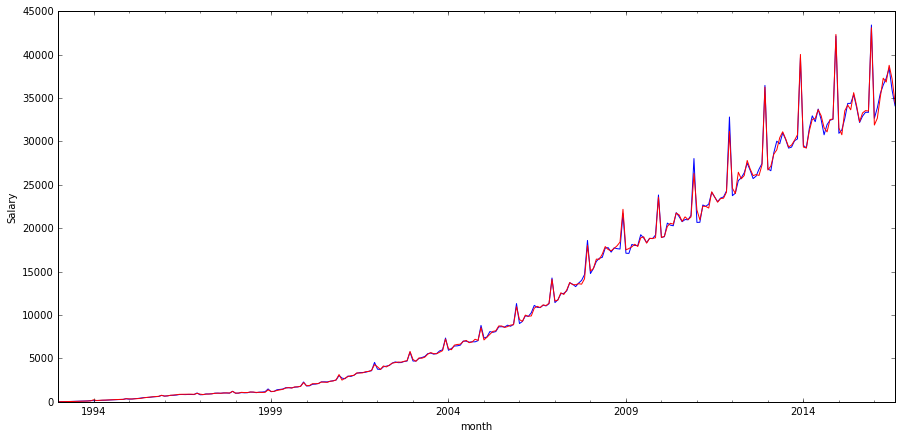

In [17]:
data['model'] = invboxcox(best_model.fittedvalues, l_value)
plt.figure(figsize(15,7))
data.salary.plot()
data.model.plot(color='r')
plt.ylabel('Salary')
pylab.show()

### Выглядит неплохо, построим предсказания


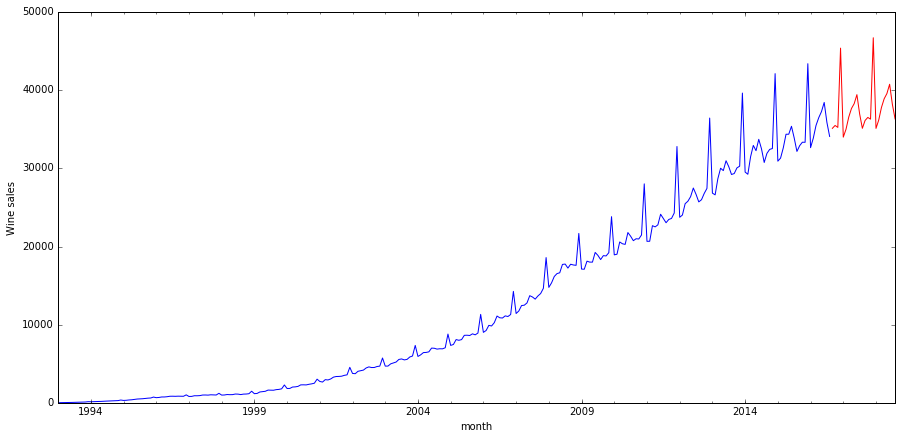

In [18]:
from datetime import datetime, timedelta

dates = []
max_date = data.index.max()
max_date_idx = len(data.index)

for i in range(25):
    dates.append((max_date + relativedelta(months=i)))

future = pd.DataFrame(index=dates, columns=data.columns)
data_f = pd.concat([data, future])

data_f['forecast'] = invboxcox(best_model.predict(start=max_date_idx, end=max_date_idx+len(dates)), l_value)

plt.figure(figsize(15,7))
data.salary.plot()
data_f.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()
